In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pickle
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import model_selection
from tqdm import notebook

BASE_DIR = '../../../'
import sys
sys.path.append(BASE_DIR)

# custom code
import utils.utils
CONFIG = utils.utils.load_config("../../config.json")

Using TensorFlow backend.


In [3]:
DATASET = os.path.basename(os.getcwd()) # name of folder this file is in
RANDOM_SEED = CONFIG['random_seed']
HYPER_TRAIN_SPLIT = CONFIG["experiment_configs"][DATASET]["hyper_train_split"]
HYPER_VAL_SPLIT = CONFIG["experiment_configs"][DATASET]["hyper_val_split"]
VAL_FULL_SPLIT = CONFIG["experiment_configs"][DATASET]["val_full_split"]

print(DATASET, RANDOM_SEED)

# folders for processed, models
DATA_F = os.path.join(BASE_DIR, f"data/adience/")
PROCESSED_DIR = os.path.join(BASE_DIR, f'processed/{DATASET}/rs={RANDOM_SEED}')
MODELS_DIR = os.path.join(BASE_DIR, f'models/{DATASET}/rs={RANDOM_SEED}')

# processing saved here
if os.path.exists( os.path.join(PROCESSED_DIR, "train.csv") ):
    print(f"warning: processing has been done for rs={RANDOM_SEED}")

adience 45


In [4]:
os.makedirs(PROCESSED_DIR, exist_ok=True)
os.makedirs(MODELS_DIR, exist_ok=True)

In [5]:
def load_faces_df():
    csvs = list()
    for i in range(5):
        df_faces_i = pd.read_csv( os.path.join(DATA_F, f"fold_{i}_data.txt"), sep='\t')
        df_faces_i['fold'] = i
        csvs.append(df_faces_i)
    return pd.concat(csvs).reset_index(drop=True)

In [6]:
df_faces = load_faces_df()

In [7]:
def get_im_path(df, idx):
    prefix = 'coarse_tilt_aligned_face'
    uid = df['user_id'].loc[idx]
    iname = df['original_image'].loc[idx]
    fid = df['face_id'].loc[idx]
    full_iname = f"{prefix}.{fid}.{iname}"
    return os.path.join(DATA_F, "faces", uid, full_iname)

def load_im(df, idx):
    ipath = get_im_path(df, idx)
    print(ipath)
    return plt.imread(ipath)

../../../data/adience/faces/30601258@N03/coarse_tilt_aligned_face.1.10399646885_67c7d20df9_o.jpg
(600, 764, 3)


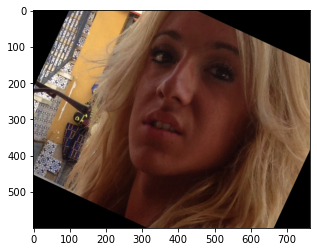

In [8]:
im = load_im(df_faces, 0)
print(im.shape)
plt.imshow(im)

In [9]:
# how many are na?
print( df_faces['age'].isna().sum() )

# unknown gender labels. official adience code just drops it
print( df_faces['gender'].isna().sum() )
print( (df_faces['gender']=='u').sum() )

0
779
1099


In [10]:
valid_age_groups = [
    '(0, 2)',
    '(4, 6)',
    '(8, 12)',
    '(15, 20)',
    '(25, 32)',
    '(38, 43)',
    '(48, 53)',
    '(60, 100)',
]

valid_ages_idx = df_faces['age'].apply(lambda x: x in valid_age_groups)
# remove the invalid age groups
df_faces = df_faces[valid_ages_idx].reset_index(drop=True)

valid_gender_groups = ['m', 'f']
valid_gender_idx = df_faces['gender'].apply(lambda x: x in valid_gender_groups)
# remove the invalid gender groups
df_faces = df_faces[valid_gender_idx].reset_index(drop=True)

In [11]:
df_faces.shape

(16228, 13)

We will make the following:
- train
- hyper train (same distribution as train; tells us when to stop fitting on train)
- val
- hyper val (same distribuition as val/test; tells us when to stop fitting on val)
- test 

Each will be symlinked to look as follows on disk:
```
data/adience
│───train
│   │─── age group 1
|   |    |─── img 1
|   |    |─── ...
│   │─── age group 2
|   |    |─── img 2
|   |    |─── ...
│   │─── ...
│   │
│───val
│   │─── age group 1
|   |    |─── img 3
|   |    |─── ...
│   │─── age group 2
|   |    |─── img 4
|   |    |─── ...
│   │─── ...
│   │
│───...
```

In [12]:
drop_cols = ['x', 'y', 'dx', 'dy', 'tilt_ang', 'fiducial_yaw_angle', 'fiducial_score', 'fold']

In [13]:
df_faces.drop(drop_cols, axis=1, inplace=True)

In [14]:
df_faces.head()

,user_id,original_image,face_id,age,gender
0,30601258@N03,10399646885_67c7d20df9_o.jpg,1,"(25, 32)",f
1,30601258@N03,10424815813_e94629b1ec_o.jpg,2,"(25, 32)",m
2,30601258@N03,10437979845_5985be4b26_o.jpg,1,"(25, 32)",f
3,30601258@N03,10437979845_5985be4b26_o.jpg,3,"(25, 32)",m
4,30601258@N03,11816644924_075c3d8d59_o.jpg,2,"(25, 32)",m


In [15]:
def create_train_test(df):
    test_ages = ['(38, 43)', '(48, 53)','(60, 100)']
    test_idx = df['age'].apply(lambda x: x in test_ages)
    return df[~test_idx], df[test_idx]

In [16]:
df_faces_train, df_faces_test = create_train_test(df_faces)

In [17]:
def get_age_and_gender(df):
    age_and_gender = [(df['age'].values[i], df['gender'].values[i]) for i in range(len(df))]
    return age_and_gender

# split off a hyper-train for optimizing on train
age_and_gender = get_age_and_gender(df_faces_train)
df_faces_train, df_faces_hyper_train = model_selection.train_test_split(
    df_faces_train,
    test_size=HYPER_TRAIN_SPLIT,
    stratify=age_and_gender,
    random_state=RANDOM_SEED,
)

# split off a val from the test set
age_and_gender = get_age_and_gender(df_faces_test)
df_faces_test, df_faces_val_full = model_selection.train_test_split(
    df_faces_test,
    test_size=VAL_FULL_SPLIT,
    stratify=age_and_gender,
    random_state=RANDOM_SEED,
)

# split off a hyper val from the val set
age_and_gender = get_age_and_gender(df_faces_val_full)
df_faces_val, df_faces_hyper_val = model_selection.train_test_split(
    df_faces_val_full,
    test_size=HYPER_VAL_SPLIT,
    stratify=age_and_gender,
    random_state=RANDOM_SEED,
)

del df_faces_val_full # no longer needed

In [18]:
df_faces_train.shape, \
df_faces_hyper_train.shape, \
df_faces_val.shape, \
df_faces_hyper_val.shape, \
df_faces_test.shape


((9795, 5), (2449, 5), (398, 5), (399, 5), (3187, 5))

In [19]:
df_faces_train.reset_index(drop=True, inplace=True)
df_faces_hyper_train.reset_index(drop=True, inplace=True)
df_faces_val.reset_index(drop=True, inplace=True)
df_faces_hyper_val.reset_index(drop=True, inplace=True)
df_faces_test.reset_index(drop=True, inplace=True)

In [20]:
for f in ['train', 'hyper_train', 'val', 'hyper_val', 'test']:
    fpath = os.path.join(PROCESSED_DIR, f)
    os.makedirs(fpath, exist_ok=False)
    for l in valid_gender_groups:
        os.makedirs(os.path.join(fpath, l), exist_ok=False)

In [21]:
def symlink_df(df, folder):
    for i in notebook.tqdm(df.index):
        src = os.path.abspath( get_im_path(df, i) )
        gender = df['gender'].loc[i]
        # get the file extension
        ext = src.split('.')[-1]
        dst_iname = f"{i}.{ext}"
        dest = os.path.join(PROCESSED_DIR, folder, gender, dst_iname)
        if os.symlink(src, dest, target_is_directory = False) != None:
            raise ValueError("error creating symlink")

In [22]:
symlink_df(df_faces_train, "train")

In [23]:
symlink_df(df_faces_hyper_train, "hyper_train")

In [24]:
symlink_df(df_faces_val, "val")

In [25]:
symlink_df(df_faces_hyper_val, "hyper_val")

In [26]:
symlink_df(df_faces_test, "test")

In [27]:
df_faces_train.to_csv( os.path.join(PROCESSED_DIR, "train.csv"), index=False )
df_faces_hyper_train.to_csv( os.path.join(PROCESSED_DIR, "hyper_train.csv"), index=False )
df_faces_val.to_csv( os.path.join(PROCESSED_DIR, "val.csv"), index=False )
df_faces_hyper_val.to_csv( os.path.join(PROCESSED_DIR, "hyper_val.csv"), index=False )
df_faces_test.to_csv( os.path.join(PROCESSED_DIR, "test.csv"), index=False )